In [1]:
import numpy as np
import matplotlib.pyplot as plt

g = 9.8

We want to solve the EOM of a ball falling down a curve. If the  curve is given by an equation $y(x) = f(x)$ we can define the tangent angle $\tg{\theta} = -dy/dx$. This enables us to write the mechanics of the system as

\begin{cases}
    \frac{dx}{dt} = v\cos{\theta} \\
    \frac{dy}{dt} = v\sin{\theta} \\
    \frac{dv}{dt} = g\sin{\theta}
\end{cases}

where,

$\cos{\theta} = \frac{1}{\sqrt{1+f'(x)^2}}$

$\sin{\theta} = \frac{-f'(x)}{\sqrt{1+f'(x)^2}}$

In our case we will model the curve as,

$f(x) = -x + a\sin{x} + b\sin{2x} + c\sin{3x} + d\sin{4x}$

for given constants $a$, $b$, $c$, $d$.

This system of ODEs is already writen in a form suitable for the use of RK4, and the equation for $y$ is meaningless because it's  a constraint on the system ($y(t)  = f(x(t))$)

We will first define the RK4 method including a set of parameters that will be $a,b,c,d$ in $f(x)$. Also, because we want to ultimately get $T(a,b,c,d)$ the final time it takes the ball to reach $x = \pi$ depending on the parameter $a,b,c,d$, we will also modify the RK4 method to stop when $x = x_f$, a final position that can be an inputto the integrator.

In [2]:
def rungeKutta4(operator, initCond, finalPos, initTime, dt, params):
    ''' 
    Modification of the RK4 method that integrates only until x(t) reaches an amount (pi in this problem).
    
    Parameters
        ----------
        operator  : function
            function of time (: float) and the y (: float / numpy.array)
            NOTICE: it must a function of both variables even if not explicitly dependent on both
            For instance:   lambda t, y: np.sin(y)    and not     lambda y: np.sin(y) 
        initCond  : float / numpy.array
            initial condition, i.e. y(t = initial time)
        finalPos: float
            final position to integrate
        initTime  : float
            initial time
        dt        : float
            time interval
        params     : float
            arguments passed down to the derivative function, in our case a,b,c,d
        
    Returns
        ----------
        times : numpy.array
            numpy array of all the calculated times
        solution : numpy.array
            numpy array of all the calculated y's
    '''
    a, b, c, d = params #This probably not the cleanest way to deal with the arguments
    
    times = [initTime]
    solut = [initCond]

    #Because we drop the ball from position x = 0  with null velocity
    #It will only move forward. We will run the script until
    #the ball reaches the desired finalPos or if it stops before (check if velocity falls under threshold)

    while solut[-1][0] <= finalPos:
        k1 = dt * operator(times[-1], solut[-1], a, b, c, d)
        k2 = dt * operator(times[-1] + dt/2, solut[-1] + k1/2, a, b, c, d)
        k3 = dt * operator(times[-1] + dt/2, solut[-1] + k2/2, a, b, c, d)
        k4 = dt * operator(times[-1] + dt, solut[-1] + k3, a, b, c, d)
        solut.append(solut[-1] + (k1 + 2*k2 + 2*k3 + k4)/6)
        times.append(times[-1]+dt)
        if times[-1] > 10:
            return times, np.array(solut)
    return times, np.array(solut)

Now we define the function and its first derivative

In [3]:
def f(x, a, b, c, d):
    '''
    The slope for the integration defined above
    '''
    return -x + a*np.sin(x) + b*np.sin(2*x) + c*np.sin(3*x) +  d*np.sin(4*x)

#We also need the derivatives of the slope

def df(x, a, b, c, d):
    '''
    First derivative of the slope
    '''
    return -1 + a*np.cos(x) + 2*b*np.cos(2*x) + 3*c*np.cos(3*x) +  4*d*np.cos(4*x)

And finally  we define the right side of the ODE system mentioned earlier

In [4]:
def F(t,u, a = 0, b = 0, c = 0, d = 0):
    '''
    u = (x,v)
    It's a straight forward implementation of the rhs of the system of ODEs
    '''
    x,v = u
    sintheta = -df(x,a,b,c,d)/np.sqrt(1+df(x,a,b,c,d)**2)
    costheta = 1/np.sqrt(1+df(x,a,b,c,d)**2)
    dx = v*costheta
    dv = g*sintheta

    return np.array([dx, dv])

We can now try to solve for a particular $f(x)$

1.0800000000000007


Text(0, 0.5, 'Position')

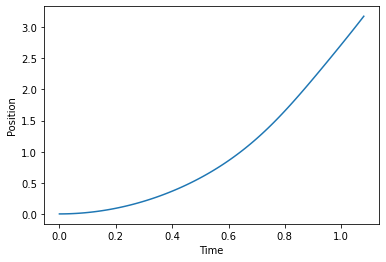

In [5]:
times, us = rungeKutta4(F, [0,0], np.pi, 0, 10e-3,[-0.3, -0.1, 0, 0])
print(times[-1])
plt.plot(times, us[:,0])
plt.xlabel('Time')
plt.ylabel('Position')

And visualize the curve it folowed

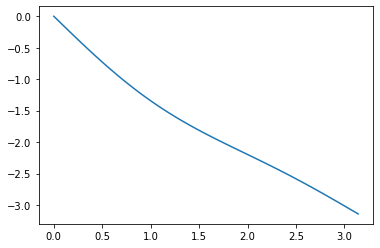

In [6]:
x = np.linspace(0,np.pi, 100)
plt.plot(x, f(x, -0.3, -0.1, 0, 0))

Now that we have a working algorithm that integrates $x(t)$ up to $x =  \pi$, we need to optimize $T(a,b,c,d)$, the total time taken to reach $x = \pi$ with respect to the coeficients of the $\sin$ functions.

We first define a function that is basically a modification of the RK4 method that only outputs the final time taken

In [7]:
def finalT(operator, initCond, finalPos, initTime, dt, *args):
    a, b, c, d = args #This probably not the cleanest way to deal with the arguments
    
    times = [initTime]
    solut = [initCond]

    #Because we drop the ball from position x = 0  with null velocity
    #It will only move forward. We will run the script until
    #the ball reaches the desired finalPos or if it stops before (check if velocity falls under threshold)

    while solut[-1][0] <= finalPos:
        k1 = dt * operator(times[-1], solut[-1], a, b, c, d)
        k2 = dt * operator(times[-1] + dt/2, solut[-1] + k1/2, a, b, c, d)
        k3 = dt * operator(times[-1] + dt/2, solut[-1] + k2/2, a, b, c, d)
        k4 = dt * operator(times[-1] + dt, solut[-1] + k3, a, b, c, d)
        solut.append(solut[-1] + (k1 + 2*k2 + 2*k3 + k4)/6)
        times.append(times[-1]+dt)
        if times[-1] > 10:
            return times[-1]
    return times[-1]

We can visualize the curve made by varying two of the four parameters

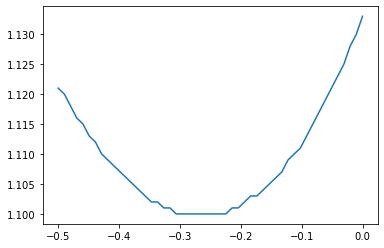

In [8]:
a = np.linspace(-0.5,0, 50)
b = np.linspace(-0.8,0,10)


T = np.zeros_like(a)

for i, ai in enumerate(a):
    T[i] = finalT(F, [0,0], np.pi,  0, 1e-3, 0, ai, 0, 0)

plt.plot(a, T)

This time function, let's  call it $T(a,b,c,d)$ is not  smooth, probably convex, and not diferentiable. This means that algorithms such as gradient descent are not even usable.

To optimize this function we could use interpolation, although 4 dimensional interpolation would be difficult due to having too many parameters in the cuadratics. Then, we are left with the Nelder-Mead algorithm, which was implemented in the Smart Traffic Lights class.

In [9]:
def NelderMeadMaximisationStep(functToUse, simplex, valueSimplex):
    
    dimension = len(valueSimplex)-1
    
    ## 1. Ordering Step
    simplexSortingIndices = valueSimplex.argsort()              # Finds the sequence of indices to sort the values
    valueSimplex          = valueSimplex[simplexSortingIndices] # Orders the values at the vertices by increasing value
    simplex               = simplex[:,simplexSortingIndices]    # Orders the vertices of the simplex by increasing function value

    ## 2. Centroid step
    centroid = np.sum(simplex[:,1:], axis=1)/dimension    # Finds the centroid of all vertices except worst performing one

    ## 3. Reflection step
    reflected = 2.0*centroid-simplex[:,0]    # Finds the reflected point
    valueReflected = functToUse(reflected)   # Evaluates the function at the reflected point

    ## 4. Test reflected point
    if (valueReflected > valueSimplex[1] and valueReflected <= valueSimplex[-1]):
        simplex[:,0]    = reflected
        valueSimplex[0] = valueReflected
        return simplex, valueSimplex
        
    ## 5. Expansion step
    if (valueReflected > valueSimplex[-1]):
        expansion = -centroid+2.0*reflected      # Finds the expansion point
        valueExpansion = functToUse(expansion)   # Evaluates the function at the expansion point

    ## 6. Test expansion point
        if (valueExpansion > valueReflected):
            simplex[:,0]    = expansion
            valueSimplex[0] = valueExpansion
            return simplex, valueSimplex
        else:
            simplex[:,0]    = reflected
            valueSimplex[0] = valueReflected
            return simplex, valueSimplex

    ## 7. Contraction step
    contraction = 0.5*centroid+0.5*simplex[:,0]    # Finds the contraction point
    valueContraction = functToUse(contraction)     # Evaluates the function at the contraction point

    ## 8. Test contraction step
    if (valueContraction > valueSimplex[0]):
        simplex[:,0]    = contraction
        valueSimplex[0] = valueContraction
        return simplex, valueSimplex
   
    ## 9. Shrink step
    simplex[:,:-1]    = (0.5*simplex[:,:-1].T + 0.5*simplex[:,-1]).T
    valueSimplex[:-1] = functToUse(simplex[:,:-1])  
    return simplex, valueSimplex


def NelderMeadMaximisation(functToUse, initialSimplex, positionToleranceAbsolute, 
                               valueToleranceAbsolute, maxNumberIteration):

    dimension = len(initialSimplex)
    
    simplex = np.copy(initialSimplex)    # Constructs initial coordinates of the simplex
    valueSimplex = functToUse(simplex)   # Evaluates the function to maximise on the vertices of the simplex

    newPosAverage   = np.sum(simplex,axis=1)/(dimension+1)
    newValueAverage = np.sum(valueSimplex)/(dimension+1)

    positionError  = 10 * abs(positionToleranceAbsolute) + 1
    valueError     = 10 * abs(valueToleranceAbsolute) + 1

    iteration = 0
    
    while (positionError > positionToleranceAbsolute and valueError > valueToleranceAbsolute) \
            and iteration < maxNumberIteration:
        print('Iteration: '+str(iteration))
        iteration += 1
        oldPosAverage   = newPosAverage
        oldValueAverage = newValueAverage
        simplex, valueSimplex = NelderMeadMaximisationStep(functToUse, simplex, valueSimplex)

        newPosAverage   = np.sum(simplex,axis=1)/(dimension+1)
        newValueAverage = np.sum(valueSimplex)/(dimension+1)

        positionError =np.linalg.norm(newPosAverage-oldPosAverage)
        valueError = np.abs(newValueAverage-oldValueAverage)
    
    return simplex[:,-1], valueSimplex[-1], iteration

To be able to use this algorithm, we have to vectorise the function finalT that we defined before. It's quite straight forward to do so. Also, because this is a Maximization method, we can just use it with -finalT.

To make this work we should make finalT only take as an argument an array of parameter (4,N). It should have as an output an array (N) with the times taken to reach $x = \pi$. So we are going to fix the other parameters currently present in finalT.

In [10]:
def finalT_vec(params, initCond = [0,0], finalPos = np.pi, initTime = 0, dt = 1e-4):
    a, b, c, d = params #This probably not the cleanest way to deal with the arguments
    dim = np.ndim(a)

    if dim == 0:
        #If the input is a 1D array of 4 parameters we need to treat it as a special case, no different from the finalT function previously defined
        times = [initTime]
        solut = [initCond]

        while solut[-1][0] <= finalPos and times[-1] < 2:
            k1 = dt * F(times[-1], solut[-1], a, b, c, d)
            k2 = dt * F(times[-1] + dt/2, solut[-1] + k1/2, a, b, c, d)
            k3 = dt * F(times[-1] + dt/2, solut[-1] + k2/2, a, b, c, d)
            k4 = dt * F(times[-1] + dt, solut[-1] + k3, a, b, c, d)
            solut.append(solut[-1] + (k1 + 2*k2 + 2*k3 + k4)/6)
            times.append(times[-1]+dt)
            
        return -times[-1]
    else:
        #If the input is a (4,N) array we  can iterate through the number of dimensions like this
        N = len(a)
        final_times = []
        for i in range(N):
            ai = a[i]
            bi = b[i]
            ci = c[i]
            di = d[i]

            times = [initTime]
            solut = [initCond]

            while solut[-1][0] <= finalPos and times[-1] < 2:
                k1 = dt * F(times[-1], solut[-1], ai, bi, ci, di)
                k2 = dt * F(times[-1] + dt/2, solut[-1] + k1/2, ai, bi, ci, di)
                k3 = dt * F(times[-1] + dt/2, solut[-1] + k2/2, ai, bi, ci, di)
                k4 = dt * F(times[-1] + dt, solut[-1] + k3, ai, bi, ci, di)
                solut.append(solut[-1] + (k1 + 2*k2 + 2*k3 + k4)/6)
                times.append(times[-1]+dt)
            final_times.append(-times[-1])

        return np.array(final_times)

Now for some reason the NM method in this case is very dependent on the initial simplex  chosen. This next cell takes about 50 seconds to run. It can be shortened to around 10 seconds if dt is streched to $dt =  1e-3$, but a bit of precission is lost

In [11]:
initialSimplex = np.array([[-0.7, 0 , 0],
                           [-0.5, 0, 0], 
                           [0, -0.4, 0],
                           [0 , 0 , -0.3]])

output = NelderMeadMaximisation(finalT_vec, initialSimplex, 1e-6, 1e-6, 30)
parameters = output[0]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12


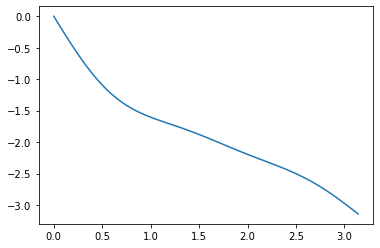

In [12]:
parameters
x = np.linspace(0,np.pi, 100)
plt.plot(x, f(x,parameters[0], parameters[1], parameters[2], parameters[3]))